## Importing Packages and Libraries

In [3]:
import numpy as np
import pandas as pd
import psycopg2
import socket
import sys
import os
import getpass
from collections import OrderedDict
from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru
import matplotlib
import matplotlib.pyplot as plt
# from __future__ import print_function
%matplotlib notebook

In [5]:
def execute_query_safely(sql, con):
    cur = con.cursor()
    try:
        cur.execute(sql)
    except:
        cur.execute('rollback;')
        raise
    finally:
        cur.close()
    return

In [6]:
sqluser = getpass.getuser()
print('Using username {}'.format(sqluser))

dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'

Using username harnoor_dhingra


In [7]:
con = psycopg2.connect(dbname=dbname, user=sqluser, port = 5433)
print('Connected to postgres {}.{}.{}!'.format(int(con.server_version/10000),(con.server_version - int(con.server_version/10000)*10000)/100,(con.server_version - int(con.server_version/100)*100)))

Connected to postgres 12.0.03.3!


In [8]:
query = query_schema + "select * from sepsis3_cohort"
co = pd.read_sql_query(query,con)

In [13]:
print('Initial Size of Cohort: {} ICU stays'.format(co.shape[0]))
idxRem = np.zeros(co.shape[0])
for c in co.columns:
    if c.startswith('exclusion_'):
        print('  {:5g} ({:2.2f}%) - {}'.format(np.sum(co[c]),np.mean(co[c])*100.0, c))
        idxRem[co[c].values==1] = 1
print('Final cohort size: {} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))

Initial Size of Cohort: 61532 ICU stays
  15056 (24.47%) - exclusion_secondarystay
   8109 (13.18%) - exclusion_nonadult
   7343 (11.93%) - exclusion_csurg
  37912 (61.61%) - exclusion_carevue
   9550 (15.52%) - exclusion_early_suspicion
   2808 (4.56%) - exclusion_late_suspicion
    491 (0.80%) - exclusion_bad_data
Final cohort size: 11325.0 ICU stays (18.41%).


In [17]:
print('Cohort - initial size: {} ICU stays'.format(co.shape[0]))
COL_REM = ['exclusion_nonadult', 'exclusion_secondarystay', 'exclusion_csurg','exclusion_carevue', 'exclusion_early_suspicion', 'exclusion_late_suspicion', 'exclusion_bad_data']
idxRem = np.zeros(co.shape[0])
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/co.shape[0], c))
    idxRem[co[c].values==1] = 1
print('Final non-suspected cohort size: {:g} ICU stays ({:2.2f}%).'.format(co.shape[0] - np.sum(idxRem), (1-np.mean(idxRem))*100.0))
print()
print('=============================')
print('====== METAVISION ONLY ======')
print('          Patients')
print('=============================')
print()
idxRem = co['dbsource']!='metavision'
N = np.sum(~idxRem)
N_IGNORE = np.sum(idxRem)
print('Cohort - initial size: {} ICU stays'.format(N))
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    print('  {:5g} ({:2.2f}%) - {}'.format(N_REM,N_REM*100.0/N, c))
    idxRem[co[c].values==1] = True  
print('Final non-suspected cohort size: {}/{} ICU stays ({:2.2f}%).'.format(np.sum(~idxRem), N, np.sum(~idxRem)*100.0/N))
print('')
print('Of these patients...')
c='suspected_of_infection_poe'
N_REM = np.sum( (~idxRem) & (co[c].values==1) )
print('  {:5g} ({:2.2f}%) - {}'.format(N_REM, N_REM*100.0/ np.sum(~idxRem), c))

Cohort - initial size: 61532 ICU stays
   8109 (13.18%) - exclusion_nonadult
  14826 (24.09%) - exclusion_secondarystay
   5905 (9.60%) - exclusion_csurg
  18909 (30.73%) - exclusion_carevue
   1719 (2.79%) - exclusion_early_suspicion
    721 (1.17%) - exclusion_late_suspicion
     18 (0.03%) - exclusion_bad_data
Final non-suspected cohort size: 11325 ICU stays (18.41%).

====== METAVISION ONLY ======
          Patients

Cohort - initial size: 23620 ICU stays
      3 (0.01%) - exclusion_nonadult
   7536 (31.91%) - exclusion_secondarystay
   2298 (9.73%) - exclusion_csurg
      0 (0.00%) - exclusion_carevue
   1719 (7.28%) - exclusion_early_suspicion
    721 (3.05%) - exclusion_late_suspicion
     18 (0.08%) - exclusion_bad_data
Final non-suspected cohort size: 11325/23620 ICU stays (47.95%).

Of these patients...
   7122 (62.89%) - suspected_of_infection_poe


# Infection - Time Histogram

In [18]:
%matplotlib notebook

<IPython.core.display.Javascript object>


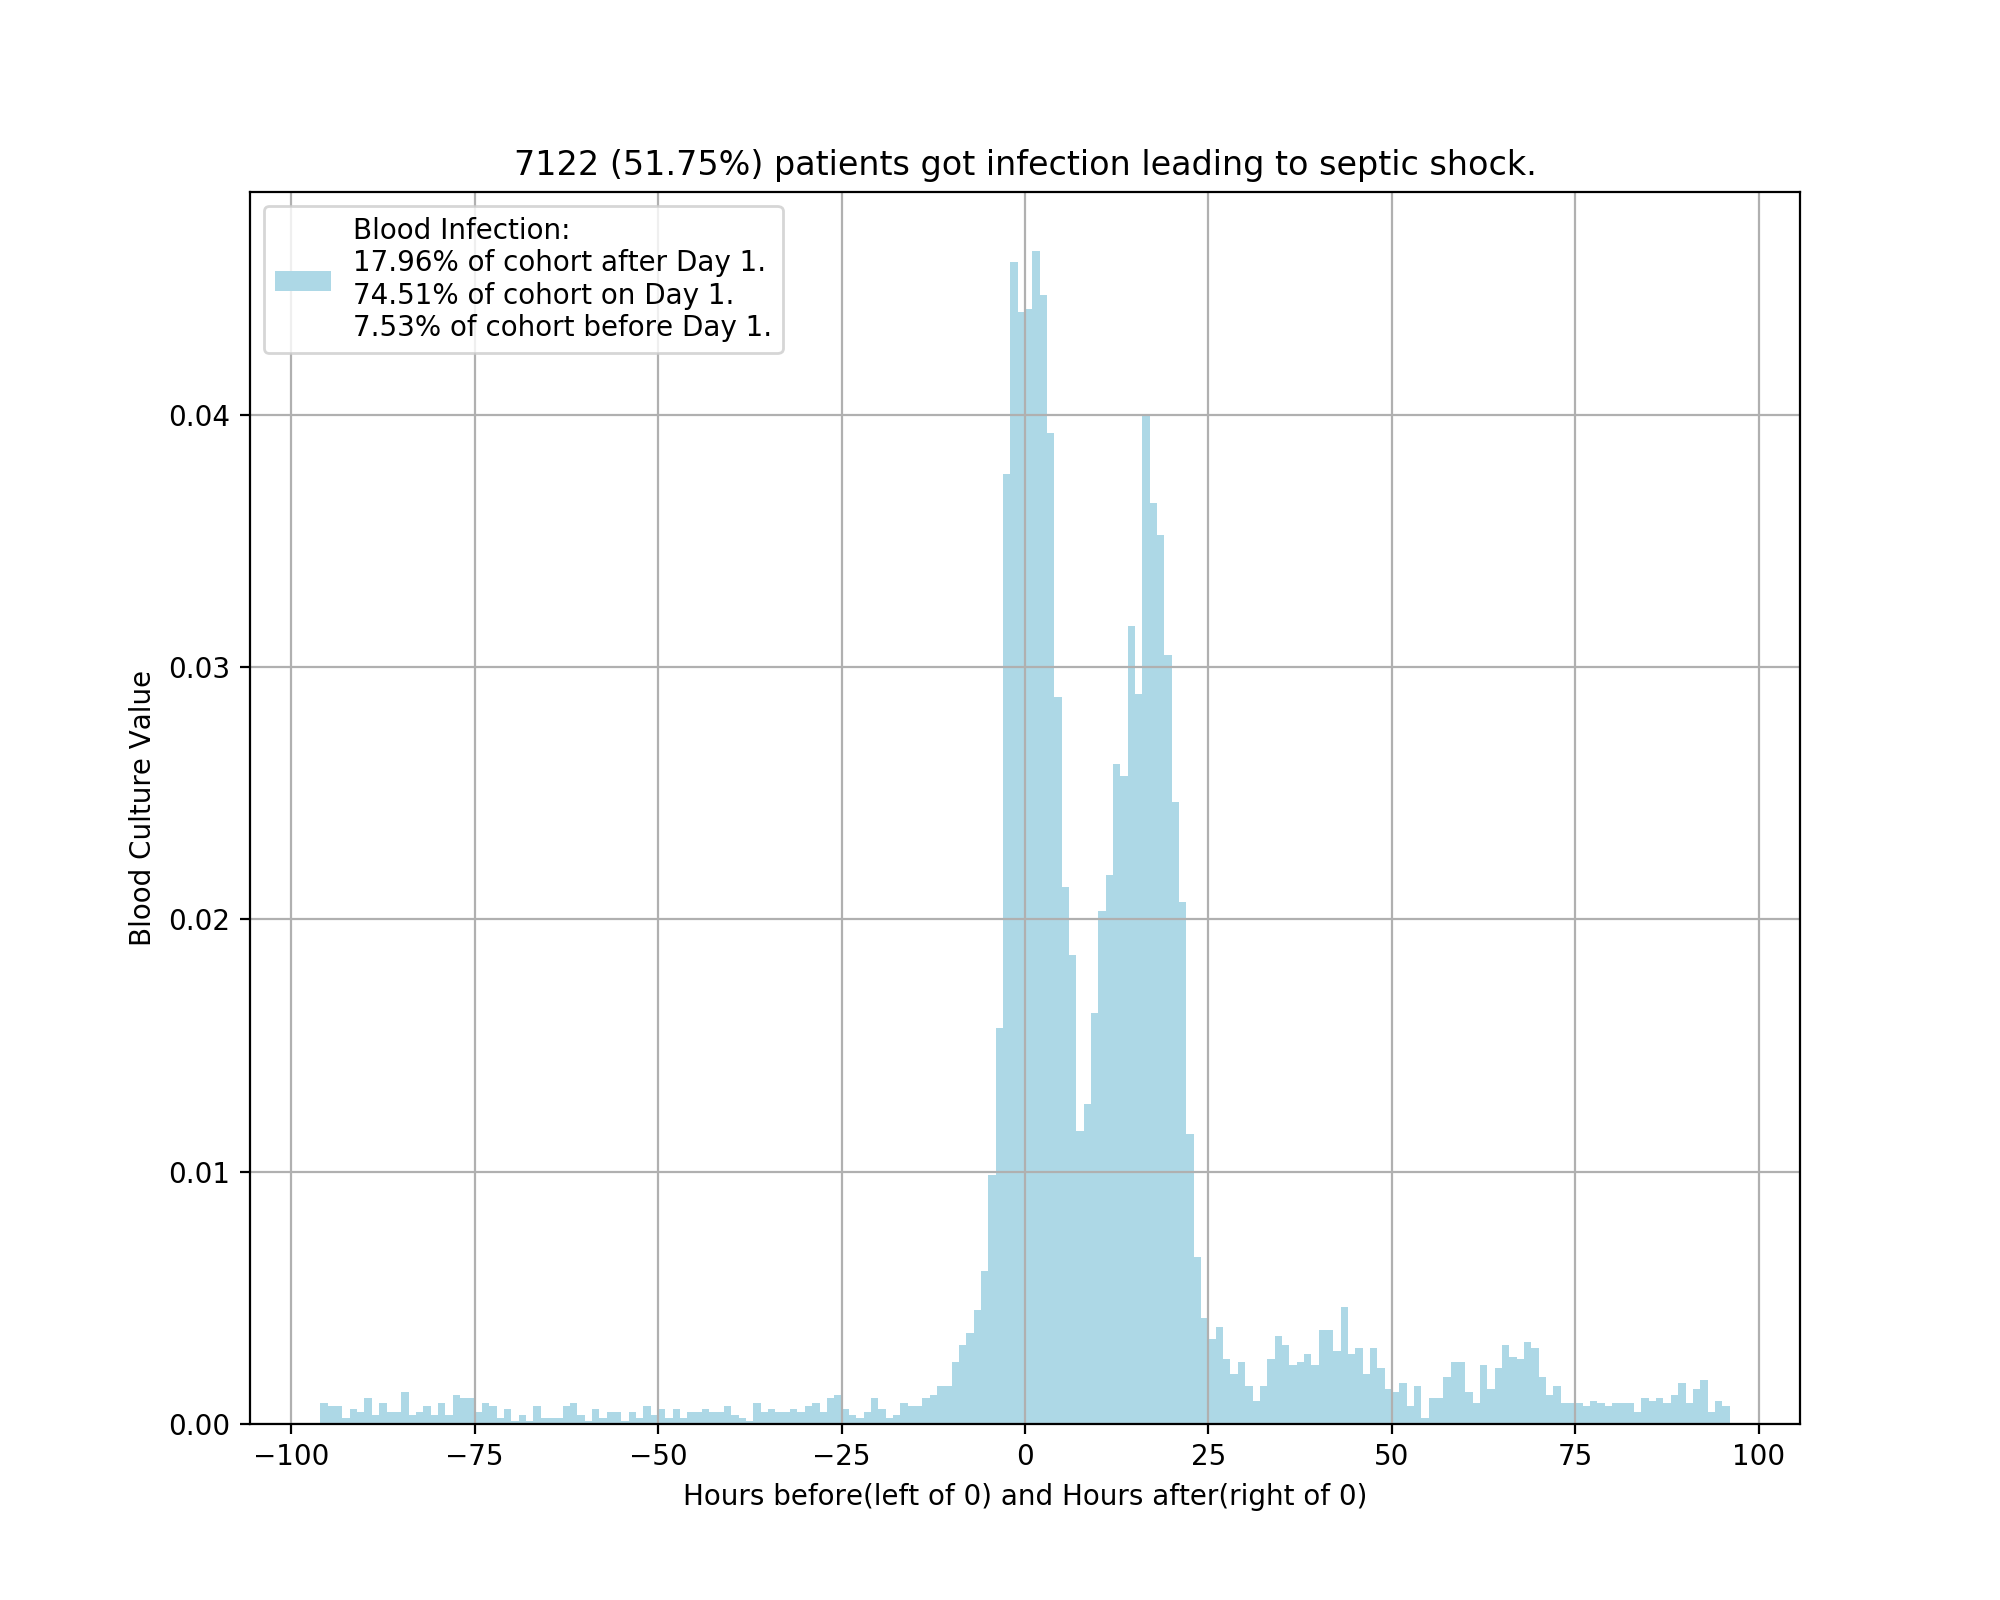

/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


In [19]:
# generate exclusions *except* early/late suspicion
COL_REM = ['exclusion_nonadult', 'exclusion_secondarystay',
           'exclusion_csurg','exclusion_carevue',
           #'exclusion_early_suspicion', 'exclusion_late_suspicion',
           'exclusion_bad_data']
idxRem = np.zeros(co.shape[0])
for c in COL_REM:
    N_REM = np.sum( (idxRem == 0) & (co[c].values==1) )
    idxRem[co[c].values==1] = 1
    
idxRem = idxRem.astype(bool)

# distribution of time of infection
N_HR = 96
xi = np.linspace(-N_HR, N_HR, N_HR*2+1)
# N_HR = 24
# xi = np.linspace(0, 200, 1)
# col = gg_color_hue(5)

pretty_dict = {'suspected_infection_time_poe_days': 'Blood Infection:'}
c = 'suspected_infection_time_poe_days'

idxKeep = ~co[c].isnull()
tmp = (co.loc[~idxRem & idxKeep, c].values * 24.0) 
# tmp = np.linspace(0, 48, 1)
N_firstday = sum( (tmp>-24) & (tmp<24) )

lbl_str = pretty_dict[c]
lbl_str += '\n' + '{:2.2f}% of cohort after Day 1.'.format(sum(tmp>24)*100.0 / np.sum(~idxRem & idxKeep))
lbl_str += '\n' + '{:2.2f}% of cohort on Day 1.'.format(sum((tmp>=-24) & (tmp<=24))*100.0 / np.sum(~idxRem & idxKeep))
lbl_str += '\n' + '{:2.2f}% of cohort before Day 1.'.format(sum(tmp<-24)*100.0 / np.sum(~idxRem & idxKeep))

# plt.figure(figsize=[14,6])
plt.figure(figsize=(10, 8), facecolor='white')
plt.hist(tmp, bins=xi, label=lbl_str, normed=True, color = 'lightblue')
plt.title('{} ({:2.2f}%) patients got infection leading to septic shock.'.format(N_firstday, N_firstday*100.0 / np.sum(~idxRem)))
plt.legend(loc='upper left')
plt.ylabel('Blood Culture Value')
plt.xlabel('Hours before(left of 0) and Hours after(right of 0)')
# plt.set_facecolor('black')
plt.grid(b=None)
    
plt.show()

It can be observed that most of the patients had infection before or at the time of ICU admission.